# Using Writer with OpenLLMetry 

This notebook shows how to monitor and debug your Writer API calls using [OpenLLMetry](https://www.traceloop.com/openllmetry). With this integration, you can trace and observe your Writer API calls alongside other LLM operations in your observability stack.

This notebook covers how to:
- Install and configure the Traceloop SDK
- Initialize Writer with observability
- Annotate workflows for better trace visualization
- Connect to external observability providers

## Prerequisites

Before starting, make sure you have:
- Python 3.11 or higher installed
- A [Writer AI Studio](https://app.writer.com/register) account
- A [Traceloop](https://auth.traceloop.com/en/login) account
- A Writer API key. See instructions in the [API Quickstart](https://dev.writer.com/api-guides/quickstart)
- Basic familiarity with Python and [OpenLLMetry concepts](https://www.traceloop.com/docs/openllmetry/introduction)

## Setup
Install OpenLLMetry in your Python environment:

In [1]:
%pip install -qU traceloop-sdk writer-sdk

Note: you may need to restart the kernel to use updated packages.


Next, set the `WRITER_API_KEY` and `TRACELOOP_API_KEY` environment variables. We recommend setting them in a `.env` file at the root of your project, but this tutorial sets them directly as environment variables if you don’t have a `.env` file.

In [2]:
import os
import getpass
from writerai import Writer

if not os.getenv("WRITER_API_KEY"):
    os.environ["WRITER_API_KEY"] = getpass.getpass("Enter your Writer API key: ")

if not os.getenv("TRACELOOP_API_KEY"):
    os.environ["TRACELOOP_API_KEY"] = getpass.getpass("Enter your Traceloop API key: ")

client = Writer(api_key=os.environ.get("WRITER_API_KEY"))

Enter your Writer API key:  ········
Enter your Traceloop API key:  ········


## Initialize Traceloop

Initialize the Traceloop tracer. For local development, you may want to disable batch sending to see traces immediately.

In [3]:
from traceloop.sdk import Traceloop

Traceloop.init(
    app_name="YOUR_APP_NAME",
    api_key=os.environ.get("TRACELOOP_API_KEY"),
    # disable_batch=True  # Optional: see traces immediately in local development
)

Traceloop exporting traces to https://api.traceloop.com authenticating with bearer token



Now that Traceloop is initialized, run a simple query using WRITER’s `palmyra-x5` model:

In [4]:
response = client.chat.chat(
    model="palmyra-x5",
    messages=[{"role": "user", "content": "Can you tell me a joke?"}],
)

print(response.choices[0].message.content)

Here's one: A man walked into a library and asked the librarian, "Do you have any books on Pavlov's dogs and Schrödinger's cat?" The librarian replied, "It rings a bell, but I'm not sure if it's here or not."


After running the chat, the following information is available in the tracing section of the TraceLoop account.

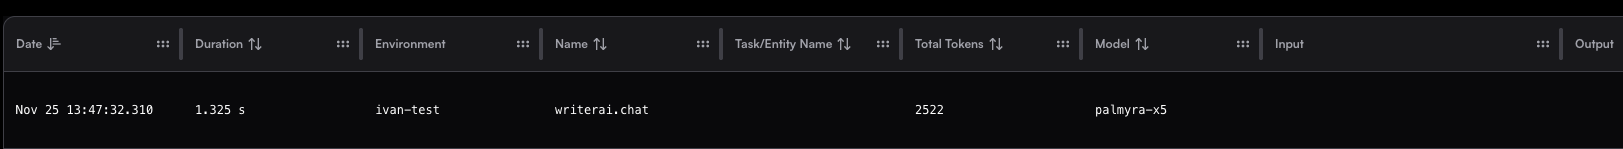

## Annotate workflows (optional)

Use [workflow annotations](https://dev.writer.com/home/integrations/openllmetry#3-optional-annotate-your-workflows) to organize traces. This is optional;  OpenLLMetry traces Writer API calls automatically without needing any decorators or additional code.

### Example: Multi-step content creation pipeline

In [5]:
from traceloop.sdk.decorators import workflow, task, agent, tool

@workflow(name="content_creation")
def content_creation_pipeline(topic: str):
    research = research_topic(topic)
    content = generate_content(research)
    return content

@task(name="research_topic")
def research_topic(topic: str):
    completion = client.chat.chat(
        model="palmyra-x5",
        messages=[{"role": "user", "content": f"Provide a comprehensive overview of {topic}."}],
        max_tokens=300
    )
    return completion.choices[0].message.content

@task(name="generate_content")
def generate_content(research: str):
    completion = client.chat.chat(
        model="palmyra-x5",
        messages=[{"role": "user", "content": f"Write an article based on this research: {research}"}],
        max_tokens=500
    )
    return completion.choices[0].message.content

#### Agent and tool decorator

You can also trace agents and their tools.

In [6]:
@agent(name="content_agent")
def content_agent(request: str):
    return research_tool(request)

@tool(name="research_tool")
def research_tool(query: str):
    completion = client.chat.chat(
        model="palmyra-x5",
        messages=[{"role": "user", "content": f"Find information about {query}."}],
        max_tokens=300
    )
    return completion.choices[0].message.content

Run a short example that invokes an agent decorated with `@agent`, which internally calls a function decorated with `@tool`. When executed, Traceloop captures traces for both the agent execution and the tool invocation.

In [8]:
content_agent(
    "Write a short technical blog post explaining how Writer integrates with OpenLLMetry, including key benefits and use cases."
)

Setting agent name: content_agent


"## Integrating with OpenLLMetry: Enhancing Observability for Large Language Models\n\nAt Writer, we're committed to providing the best possible experience for our users by leveraging the latest advancements in large language models (LLMs). To achieve this, we integrate with OpenLLMetry, an open-source observability platform designed specifically for LLMs. In this blog post, we'll explore how Writer integrates with OpenLLMetry, the key benefits of this integration, and some exciting use cases.\n\n### What is OpenLLMetry?\n\nOpenLLMetry is an open-source platform that provides comprehensive observability for LLMs. It allows developers to monitor, analyze, and optimize the performance of their LLMs, enabling them to identify areas for improvement and make data-driven decisions.\n\n### How Does Writer Integrate with OpenLLMetry?\n\nWriter's integration with OpenLLMetry enables seamless monitoring and analysis of LLM performance. By leveraging OpenLLMetry's capabilities, Writer can:\n\n1. 

After the chat completes, the information below is available in the TraceLoop account under tracing.

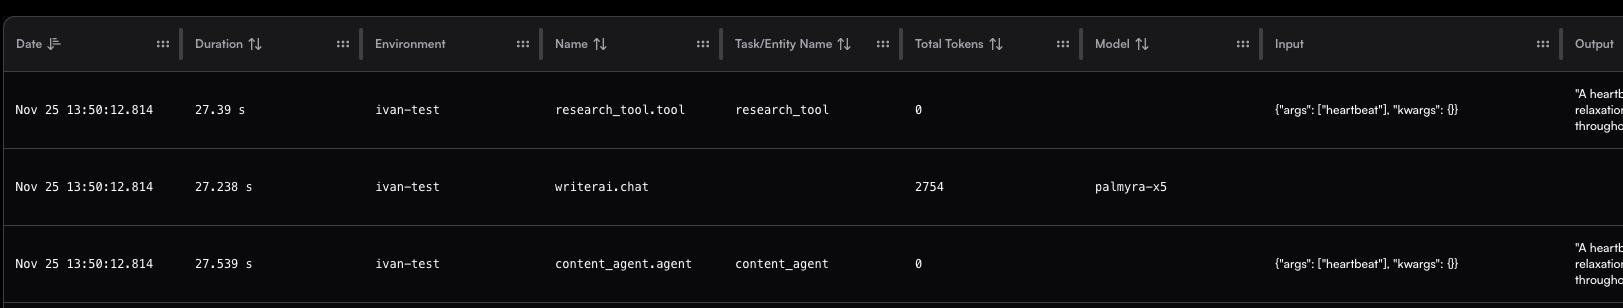


Click on the trace to see more details.

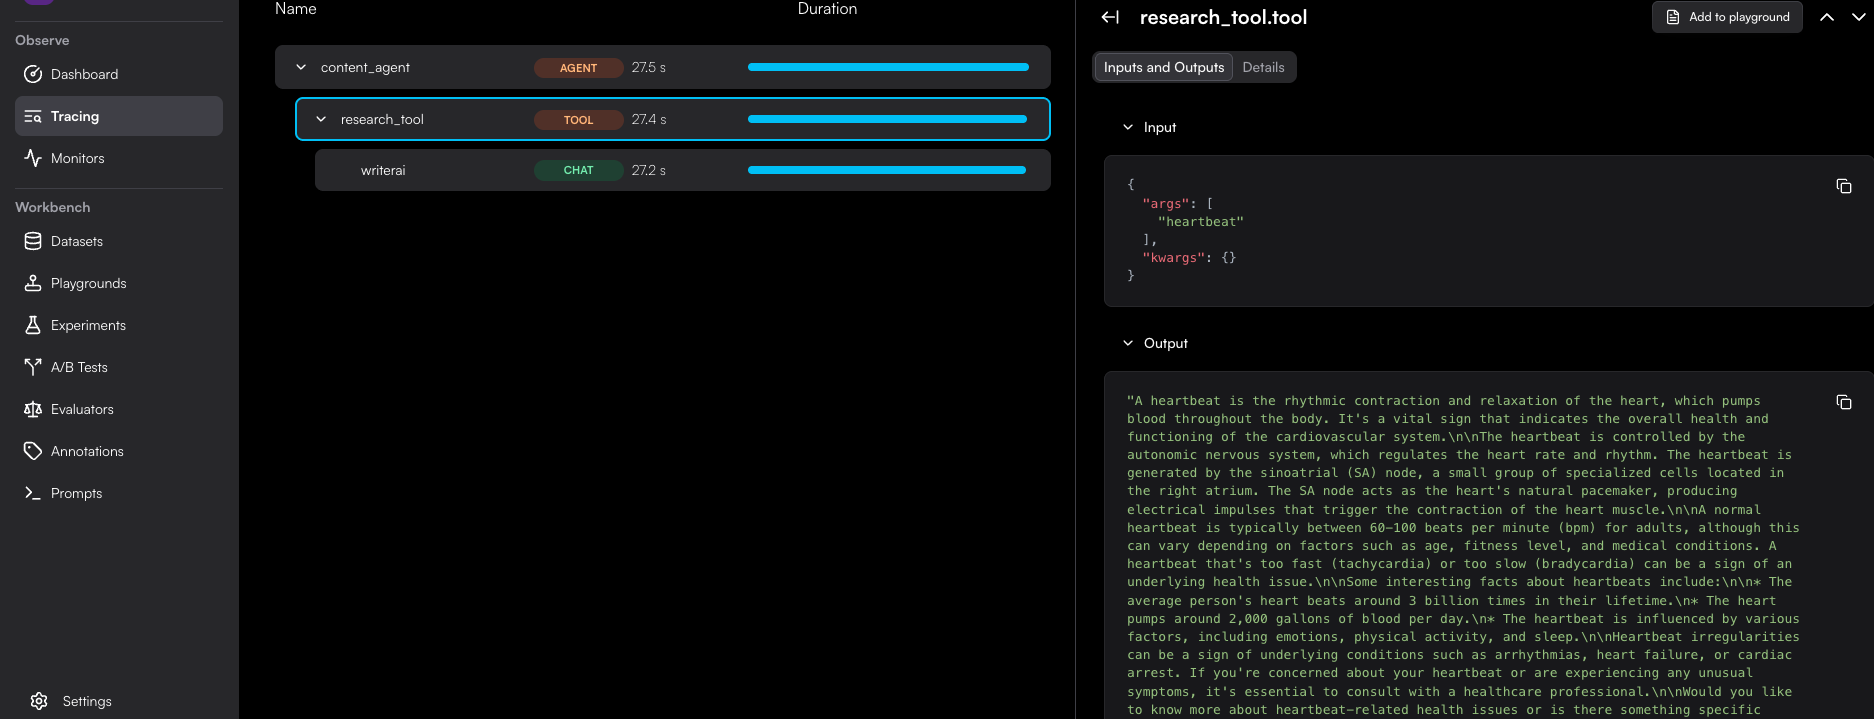